In [1]:
using OrdinaryDiffEq
using Plots

In [92]:
L=1.
M=400 # number of space-points in the discretization
t=1. # final time
dx = L/M
dt = 0.1 * dx
tol = 10^(-6) # error tolerance in inversion
iter_max = 20  # maximum number of NR iterations
U=10 # number of fields (double the number of fields, one for fluid and the other for conservative quantities)
u_i=zeros(M*U) # flux variables for the initial data (these are used for the flux function)
du=zeros(M*U) # for the rhs
x = zeros(M) # the coordinates
χ = [- 1.; - 2.; - 10.]
ξ = (49.735919716217296, 16.578639905405765) # (λ, κ) dissipative parameters
par_eq = (χ, ξ) #B parameters to use on the equations
par_inv = (χ, tol, iter_max, U, M)

([-1.0, -2.0, -10.0], 1.0000000000000004e-6, 20, 10, 400)

In [93]:
include("choques_utils.jl") # all functions needed for evolution
include("Flux_function_ext.jl")
include("inversion_ext.jl")

 Activating environment at `~/Julia/Fluidos_Conformes/Conf_Fluids/Project.toml`
  Resolving package versions...
No Changes to `~/Julia/Fluidos_Conformes/Conf_Fluids/Project.toml`
No Changes to `~/Julia/Fluidos_Conformes/Conf_Fluids/Manifest.toml`


f_to_c!

In [94]:
par = (par_eq, par_inv, 1. /dx, U, M, Flux, Speed_max, Is!, c_to_f!)

(([-1.0, -2.0, -10.0], (49.735919716217296, 16.578639905405765)), ([-1.0, -2.0, -10.0], 1.0000000000000004e-6, 20, 10, 400), 400.0, 10, 400, Flux, Speed_max, Is!, c_to_f!)

In [95]:
# the initial data
#u0=zeros(M*U) # for the initial data U0=(Sx,Sy,By)
x0 = 0.4; x1 = 0.6

con_0 = view(reshape(u_i,(M,U)),:,1:U÷2)
flu_0 = view(reshape(u_i,(M,U)),:,U÷2+1:U)

for i in 1:M
    x[i] = dx*(i-1)
    if x[i] > x0 && x[i] < x1
        flu_0[i,2] = 0.01 * (x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                    #Sz
        flu_0[i,4] = -0.0 # * sin(pi*(x[i] - x0)/(x1-x0))^4 * sin(2*pi*(x[i] - x0)/(x1-x0))     #By
        
    end
    flu_0[i,5] = 0. #Bz
    flu_0[i,1] = -1.  # μ
end

f_to_c!(u_i, (χ, U, M))
#f(du,u0,par,t);

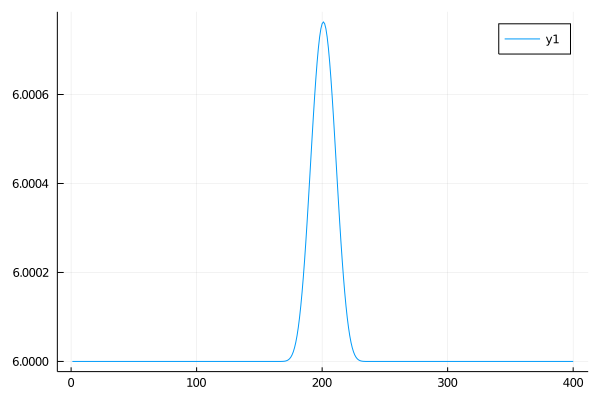

In [96]:
plot(con_0[:,1])

In [97]:
function evolution(du,u,par,t)
    # this is the function that is taken by the time-integrator
    par_eq, par_inv, h_1, U, M, Flux, Speed_max, Source, c_to_f = par
    χ, ζ = par_eq
    
    #p = (χ, U, M)
    c_to_f!(u,par_inv)
    
    par_mp5 = (h_1, U, M, χ, ζ, Flux, Speed_max, Source)
    for j ∈ 1:M
        mp5(du,u,par_mp5,j)
    end
    return du[:]
end

evolution (generic function with 1 method)

In [98]:
prob = ODEProblem(evolution,u_i,(0.0,t),par);

In [99]:
sol = solve(prob,SSPRK33(),dt=dt,saveat=0.01*t); # This, I think, is a TVD method
#sol = solve(prob,SSPRK33(),dt=dt,save_everystep=false) # to get just the end values
#sol = solve(prob,RK4(),dt=dt);

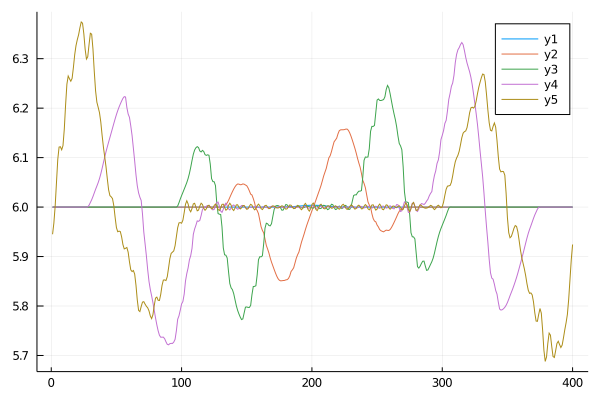

In [100]:
field = 5
plot(reshape(sol(0.),(M,U))[:,field])
plot!(reshape(sol(t/8),(M,U))[:,field])
plot!(reshape(sol(t/4),(M,U))[:,field])
plot!(reshape(sol(t/2.1),(M,U))[:,field])
plot!(reshape(sol(t/1.1),(M,U))[:,field])

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Fluidos_Conformes/ff_20_anim_fps10.gif
└ @ Plots /Users/reula/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Julia/Fluidos_Conformes/ff_20_anim_fps10.gif")
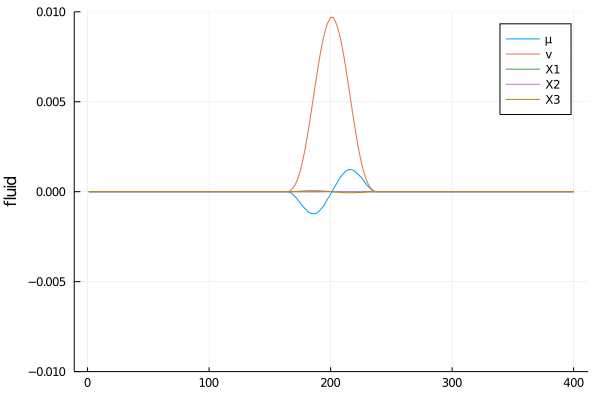

In [101]:

anim = @animate for i ∈ 1:100
    plot(reshape(sol(t*0.01*i),(M,U))[:,5+1] .+ 1.,label="μ", yaxis = ("fluid", (-0.01,0.01)))
    plot!(reshape(sol(t*0.01*i),(M,U))[:,5+2],label="v")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,5+3],label="X1")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,5+4],label="X2")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,5+5],label="X3")
end

gif(anim, "ff_20_anim_fps10.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Fluidos_Conformes/fc_20_anim_fps10.gif
└ @ Plots /Users/reula/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Julia/Fluidos_Conformes/fc_20_anim_fps10.gif")
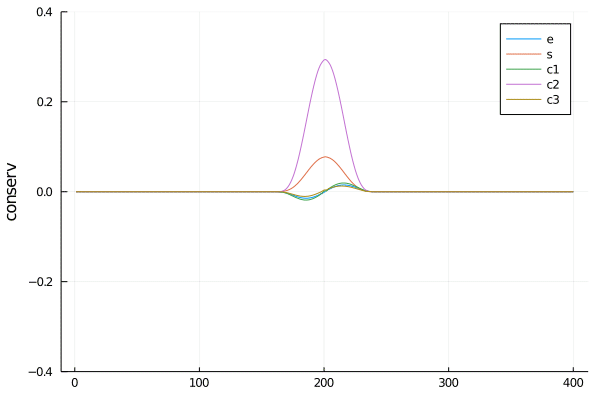

In [102]:

anim = @animate for i ∈ 1:100
    plot(reshape(sol(t*0.01*i),(M,U))[:,1] .- 6.,label="e", yaxis = ("conserv", (-0.4,0.4)))
    plot!(reshape(sol(t*0.01*i),(M,U))[:,2],label="s")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,3] .- 6,label="c1")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,4],label="c2")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,5] .- 6.,label="c3")
end

gif(anim, "fc_20_anim_fps10.gif", fps = 10)